In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras as keras

# Used for Confusion Matrix
from sklearn import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Is CUDA installed?
tf.test.is_built_with_cuda()

True

In [3]:
# Limiting GPU memory growth (stopping it crash)
# From https://www.tensorflow.org/guide/gpu

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning

# Also comments from https://github.com/SebastienMc/series_to_supervised
#     Frame a time series as a supervised learning dataset.
#     Arguments:
#         data: Sequence of observations as a list or NumPy array.
#         n_in: Number of delay or lag observations as input (X).
#         n_out: Number of observations as output (y).
#         dropnan: Boolean whether or not to drop rows with NaN values.
#     Returns:
#         Pandas DataFrame of series framed for supervised learning.

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
# load dataset
dataset = read_csv('D:/nils/projects/dissertation/dataset_cpu_hog-exp1.csv', header=0, index_col=False)
#dataset = df
dataset

,y,Automation,Access_List,Bugs,Configuration,CPU_1,Crash,Device_Hardening,Diagnostic_Signature,Diagnosis,...,Prod6052_FW_Appliance,Software,Software_Failure,Software_Limitation,System,System_Resource,Temperature,Traffic,troubleshooting,hit_severity
0,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571128,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
571129,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
571130,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
571131,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
dataset.sum()

y                                                                  11405
Automation                                                        506466
Access_List                                                        16191
Bugs                                                                 643
Configuration                                                      81419
CPU_1                                                              30197
Crash                                                               8732
Device_Hardening                                                  125682
Diagnostic_Signature                                              377464
Diagnosis                                                          17485
Failover                                                           23014
Hardware                                                            1547
Hardware_Failure                                                    1000
Hardware_Limitation                                

In [7]:
# Adapted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# This normalises the severity -  other variables are already binary factors so re not impacted

# specify the look Back
n_look_back = 15
n_features = len(dataset.columns)

values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Creates time series dataframe
# frame as supervised learning
reframed = series_to_supervised(scaled, n_look_back, 1)
print(reframed.shape)
reframed

(571118, 544)


,var1(t-15),var2(t-15),var3(t-15),var4(t-15),var5(t-15),var6(t-15),var7(t-15),var8(t-15),var9(t-15),var10(t-15),...,var25(t),var26(t),var27(t),var28(t),var29(t),var30(t),var31(t),var32(t),var33(t),var34(t)
15,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571128,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
571129,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
571130,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
571131,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# split into train and test sets
values = reframed.values
n_train_hours = int(reframed.shape[0]*.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_look_back * n_features
x_train, y_train = train[:, :n_obs], train[:, -n_features]
x_test, y_test = test[:, :n_obs], test[:, -n_features]
print(x_train.shape, len(x_train), y_train.shape)

x_train_2d = x_train
x_test_2d = x_test

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], n_look_back, n_features))
x_test = x_test.reshape((x_test.shape[0], n_look_back, n_features))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(399782, 510) 399782 (399782,)
(399782, 15, 34) (399782,) (171336, 15, 34) (171336,)


In [9]:
x_train 

n_train_hours

399782

In [10]:
# design simple network
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,409
Trainable params: 25,409
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# fit network
history = model.fit(x_train, y_train, epochs=10 , batch_size=500, validation_data=(x_test, y_test), verbose=1, shuffle=False)


Train on 399782 samples, validate on 171336 samples
Epoch 1/10
399782/399782 [==============================] - 12s 30us/step - loss: 0.0535 - accuracy: 0.9903 - val_loss: 0.2703 - val_accuracy: 0.9560
Epoch 2/10
399782/399782 [==============================] - 11s 28us/step - loss: 0.0479 - accuracy: 0.9903 - val_loss: 0.2611 - val_accuracy: 0.9560
Epoch 3/10
399782/399782 [==============================] - 11s 28us/step - loss: 0.0490 - accuracy: 0.9903 - val_loss: 0.2578 - val_accuracy: 0.9560
Epoch 4/10
399782/399782 [==============================] - 11s 28us/step - loss: 0.0491 - accuracy: 0.9903 - val_loss: 0.2531 - val_accuracy: 0.9560
Epoch 5/10
399782/399782 [==============================] - 11s 28us/step - loss: 0.0501 - accuracy: 0.9903 - val_loss: 0.2512 - val_accuracy: 0.9560
Epoch 6/10
399782/399782 [==============================] - 11s 28us/step - loss: 0.0506 - accuracy: 0.9903 - val_loss: 0.2550 - val_accuracy: 0.9560
Epoch 7/10
399782/399782 [======================

<Figure size 432x288 with 0 Axes>

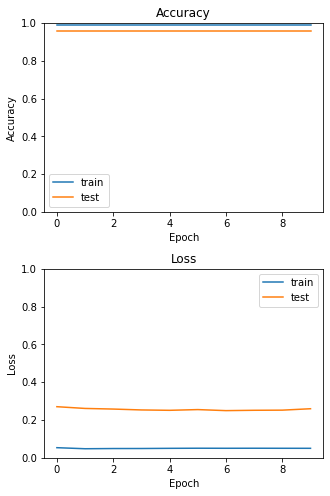

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.clf()
G = gridspec.GridSpec(2, 1,hspace=0.3)
plt.figure(figsize=(5,8))

axes_a = plt.subplot(G[0,0])
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
pyplot.legend()
plt.ylim(0,1)
#plt.xlim(0,49)

axes_b = plt.subplot(G[1,0])
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
pyplot.legend()
plt.ylim(0,1)
#plt.xlim(0,49)

plt.savefig('acc_loss_labels_plot.svg', transparent=True)
pyplot.show()

In [24]:
RNN_pred_y = model.predict(x_test, verbose=1)


171336/171336 [==============================] - 15s 86us/step


In [25]:
model.save('model_cpu_hog_labels.h5')

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, RNN_pred_y)

In [27]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

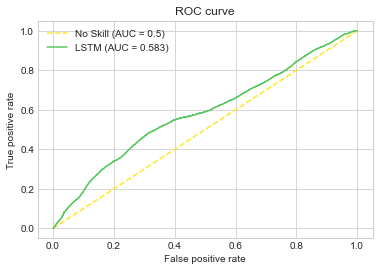

In [28]:
plt.figure(1)

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill (AUC = 0.5)')
pyplot.plot(fpr_keras, tpr_keras, marker=',', label='LSTM (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix

RNN_pred_y_class = model.predict_classes(x_test, verbose=1)



171336/171336 [==============================] - 15s 86us/step


In [30]:
def cm(y_test, pred_y_class):
    cm = metrics.confusion_matrix(y_test, pred_y_class)
    fn = cm[1][0]
    tp = cm[1][1]
    fnr = fn/(tp+fn)
    return cm, fnr


In [31]:
cmRNN, fnrRNN = cm(y_test, RNN_pred_y_class)


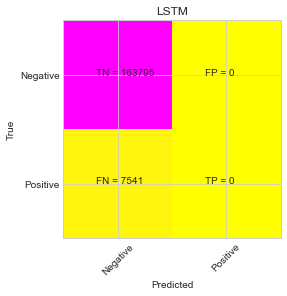

In [32]:
plt.imshow(cmRNN, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('LSTM')
plt.ylabel('True')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmRNN[i][j]))

#plt.savefig('conf1_plot.svg', transparent=True)
plt.show()

C:\Users\nilsp\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


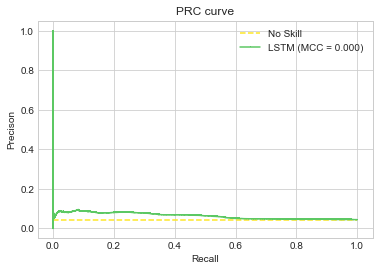

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_RNN = f1_score(y_test, RNN_pred_y_class)
MCC_RNN = matthews_corrcoef(y_test,RNN_pred_y_class)


pr_RNN, re_RNN, th = precision_recall_curve(y_test, RNN_pred_y)

plt.figure(2)
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(re_RNN, pr_RNN, marker=',', label='LSTM (MCC = {:.3f})'.format(MCC_RNN))
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.legend(loc='best')
plt.show()

In [34]:
# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression 

logReg = LogisticRegression(max_iter=10000, verbose=1)

In [36]:
logReg.fit(x_train_2d, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(max_iter=10000, verbose=1)

In [37]:
# Make predictions on entire test data
pred_y_class = logReg.predict(x_test_2d)
pred_y_prob = logReg.predict_proba(x_test_2d)
pred_y_prob = pred_y_prob[:, 1]

In [38]:
# Use score method to get accuracy of model
score = logReg.score(x_test_2d, y_test)
print(score)

0.9560279217444086


In [39]:
# confusion matrix

cmLogReg, fnrLogReg = cm(y_test, pred_y_class)

print(cmLogReg)
fnrLogReg

[[163769     26]
 [  7508     33]]


0.9956239225566901

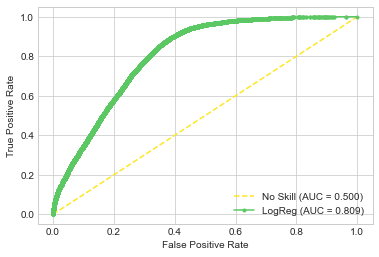

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, pred_y_prob)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, pred_y_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = {:.3f})'.format(ns_auc))
pyplot.plot(LogReg_fpr, LogReg_tpr, marker='.', label='LogReg (AUC = {:.3f})'.format(LogReg_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

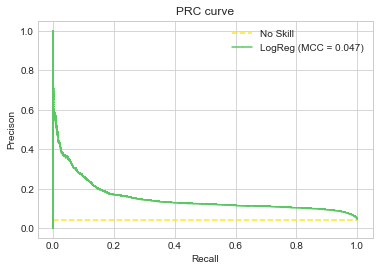

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_LogReg = f1_score(y_test, pred_y_class)
MCC_LogReg = matthews_corrcoef(y_test,pred_y_class)


pr_LogReg, re_LogReg, th = precision_recall_curve(y_test, pred_y_prob)

plt.figure(2)
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(re_LogReg, pr_LogReg, marker=',', label='LogReg (MCC = {:.3f})'.format(MCC_LogReg))
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.legend(loc='best')
plt.show()

In [42]:
# AdaBoost Classifier

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [44]:
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)
classifier.fit(x_train_2d, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

In [45]:
pred_y_class = classifier.predict(x_test_2d)
pred_y_prob = classifier.predict_proba(x_test_2d)
pred_y_prob = pred_y_prob[:, 1]

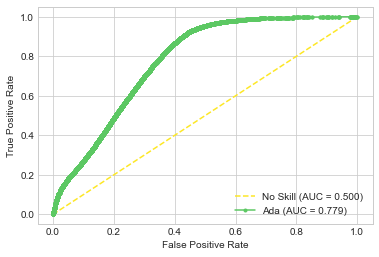

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
ada_auc = roc_auc_score(y_test, pred_y_prob)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ada_fpr, ada_tpr, _ = roc_curve(y_test, pred_y_prob)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = {:.3f})'.format(ns_auc))
pyplot.plot(ada_fpr, ada_tpr, marker='.', label='Ada (AUC = {:.3f})'.format(ada_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

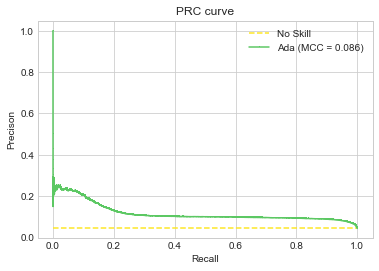

In [47]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_Ada = f1_score(y_test, pred_y_class)
MCC_Ada = matthews_corrcoef(y_test,pred_y_class)


pr_Ada, re_Ada, th = precision_recall_curve(y_test, pred_y_prob)

plt.figure(2)
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(re_Ada, pr_Ada, marker=',', label='Ada (MCC = {:.3f})'.format(MCC_Ada))
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.legend(loc='best')
plt.show()

In [48]:
cmAdaBoost, fnrAdaBoost = cm(y_test, pred_y_class)

print(cmAdaBoost)
fnrAdaBoost

[[162660   1135]
 [  7197    344]]


0.9543827078636785

In [49]:
classifier.score(x_train_2d, y_train)

0.990092100194606

In [50]:
# XGBoost

In [51]:
from xgboost import XGBClassifier, plot_importance
import pandas as pd
from sklearn.metrics import accuracy_score

In [52]:
xgb1 = XGBClassifier(max_depth=6, 
                     verbosity=2,
                     n_estimators=200, 
                     learning_rate=0.05,
                     tree_method='gpu_hist').fit(x_train_2d, y_train, eval_metric='auc')


In [53]:
    #Predict training set:
    pred_y_class = xgb1.predict(x_test_2d)
    pred_y_prob = xgb1.predict_proba(x_test_2d)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy:") 
    print (metrics.accuracy_score(y_test,pred_y_class))
    print ('AUC Score:')
    print (metrics.roc_auc_score(y_test,pred_y_prob))


Model Report
Accuracy:
0.9559870663491619
AUC Score:
0.800057303882158


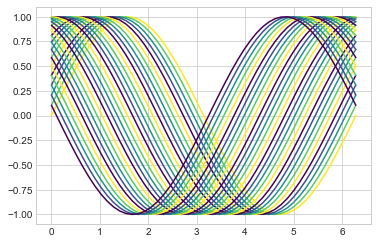

In [54]:
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np

plt.style.use('seaborn-whitegrid')

# get colormap
cmap=plt.cm.viridis_r
# build cycler with 5 equally spaced colors from that colormap
c = cycler('color', cmap(np.linspace(0,1,5)) )
# supply cycler to the rcParam
plt.rcParams["axes.prop_cycle"] = c


x = np.linspace(0,2*np.pi)
f = lambda x, phase:np.sin(x+phase)
for i in range(30):
    plt.plot(x,f(x,i/30.*np.pi) )

plt.show()

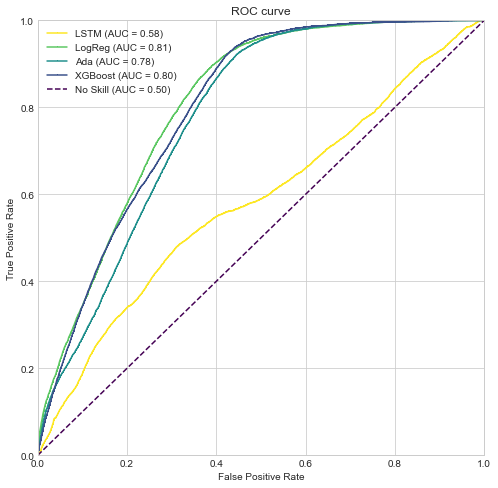

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, pred_y_prob)

plt.figure(figsize=(8,8))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, pred_y_prob)
# plot the roc curve for the model
pyplot.plot(fpr_keras, tpr_keras, marker=',', label='LSTM (AUC = {:.2f})'.format(auc_keras))
pyplot.plot(LogReg_fpr, LogReg_tpr, marker=',', label='LogReg (AUC = {:.2f})'.format(LogReg_auc))
pyplot.plot(ada_fpr, ada_tpr, marker=',', label='Ada (AUC = {:.2f})'.format(ada_auc))
pyplot.plot(xgb_fpr, xgb_tpr, marker=',', label='XGBoost (AUC = {:.2f})'.format(xgb_auc))
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = {:.2f})'.format(ns_auc))
# axis labels
plt.xlim(0,1)
plt.ylim(0,1)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
plt.title('ROC curve')
# show the legend
pyplot.legend()
# show the plot

plt.savefig('roc_labels_plot.svg', transparent=True)
pyplot.show()

C:\Users\nilsp\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


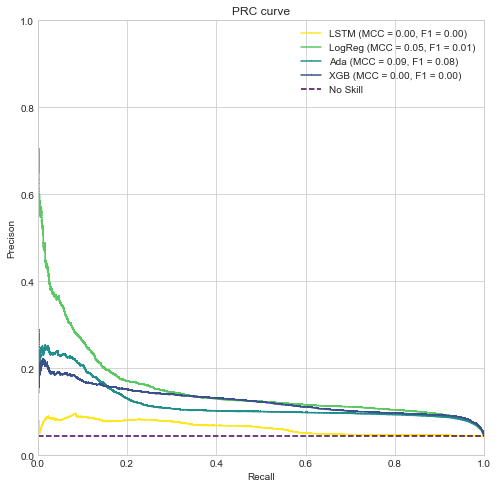

In [56]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, matthews_corrcoef
 
F1_xgb = f1_score(y_test, pred_y_class)
MCC_xgb = matthews_corrcoef(y_test,pred_y_class)

pr_xgb, re_xgb, th = precision_recall_curve(y_test, pred_y_prob)

plt.figure(figsize=(8,8))
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
pyplot.plot(re_RNN, pr_RNN, marker=',', label='LSTM (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_RNN, F1_RNN))
pyplot.plot(re_LogReg, pr_LogReg, marker=',', label='LogReg (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_LogReg, F1_LogReg))
pyplot.plot(re_Ada, pr_Ada, marker=',', label='Ada (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_Ada, F1_Ada))
pyplot.plot(re_xgb, pr_xgb, marker=',', label='XGB (MCC = {:.2f}, F1 = {:.2f})'.format(MCC_xgb, F1_xgb))
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# axis labels
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.title('PRC curve')
plt.legend(loc='best')

plt.savefig('prc_curve_labels_plot.svg', transparent=True)

plt.show()


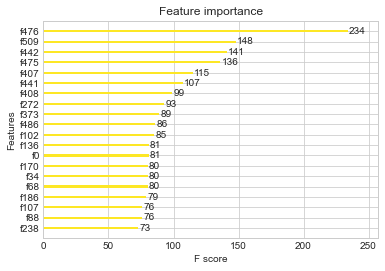

In [57]:

plot_importance(xgb1, max_num_features = 20)
pyplot.show()


In [58]:
cmXGB, fnrXGB = cm(y_test, pred_y_class)
print(cmXGB)
fnrXGB



[[163795      0]
 [  7541      0]]


1.0

<Figure size 432x288 with 0 Axes>

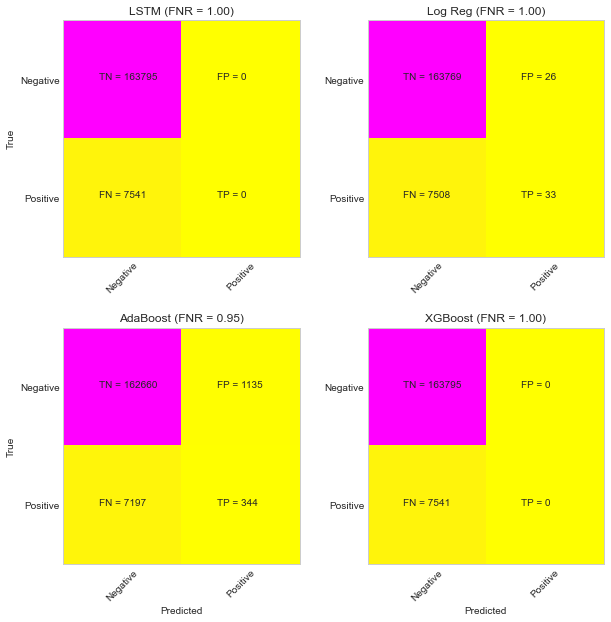

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.clf()
G = gridspec.GridSpec(2, 2,hspace=0.3)
plt.figure(figsize=(10,10))

axes_4 = plt.subplot(G[0,0])
plt.grid(b=None)
plt.imshow(cmRNN, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('LSTM (FNR = {:.2f})'.format(fnrRNN))
plt.ylabel('True')
#plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmRNN[i][j]))

axes_1 = plt.subplot(G[1,0])
plt.grid(b=None)
plt.imshow(cmAdaBoost, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('AdaBoost (FNR = {:.2f})'.format(fnrAdaBoost))
plt.ylabel('True')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmAdaBoost[i][j]))
               
axes_2 = plt.subplot(G[0,1])
plt.grid(b=None)
plt.imshow(cmLogReg, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('Log Reg (FNR = {:.2f})'.format(fnrLogReg))
#plt.ylabel('True')
#plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmLogReg[i][j]))
        
axes_3 = plt.subplot(G[1,1])
plt.grid(b=None)
plt.imshow(cmXGB, interpolation='nearest', cmap=plt.cm.spring_r)
classNames = ['Negative','Positive']
plt.title('XGBoost (FNR = {:.2f})'.format(fnrXGB))
#plt.ylabel('True')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j-0.2,i, str(s[i][j])+" = "+str(cmXGB[i][j]),)

plt.savefig('cm_labels_plot.svg', transparent=True)
plt.show()
